Current working directory: G:\My Drive\Pós-Graduação\Cronologia\Python Scripts\Density_Annealing_Model_Fit_Scripts

Fitting model: PA
Residual analysis for model PA:
Number of points: 62
Mean residual: -0.0087
Std residual: 0.0236
Mean norm residual: -1.3951
Std norm residual: 3.6798
Outliers (>3 sigma): 28 at indices [ 3  4  5  6 11 12 14 15 21 22 23 28 34 35 37 38 39 43 44 48 50 51 52 55
 56 57 60 61]


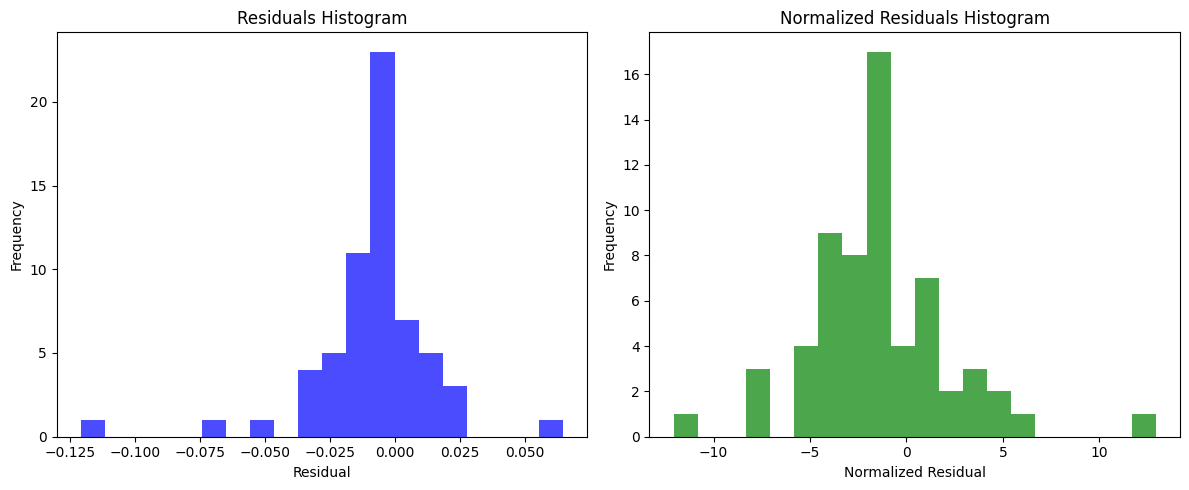

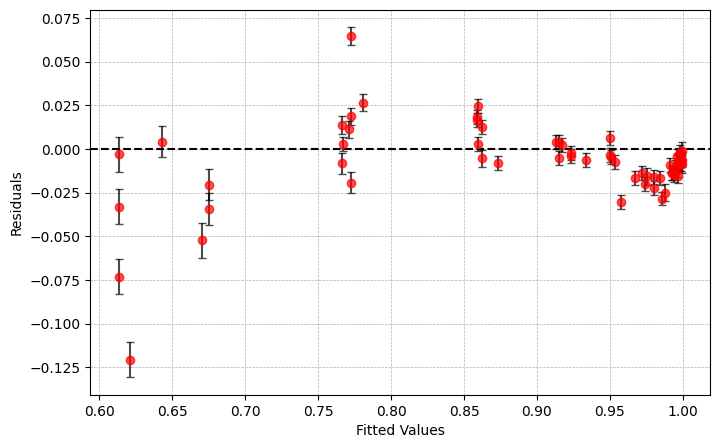


Fitting model: PC
Residual analysis for model PC:
Number of points: 62
Mean residual: -0.0071
Std residual: 0.0228
Mean norm residual: -1.0894
Std norm residual: 3.4060
Outliers (>3 sigma): 20 at indices [ 3  4  5  6 11 12 15 21 23 34 37 39 44 48 51 55 56 57 60 61]


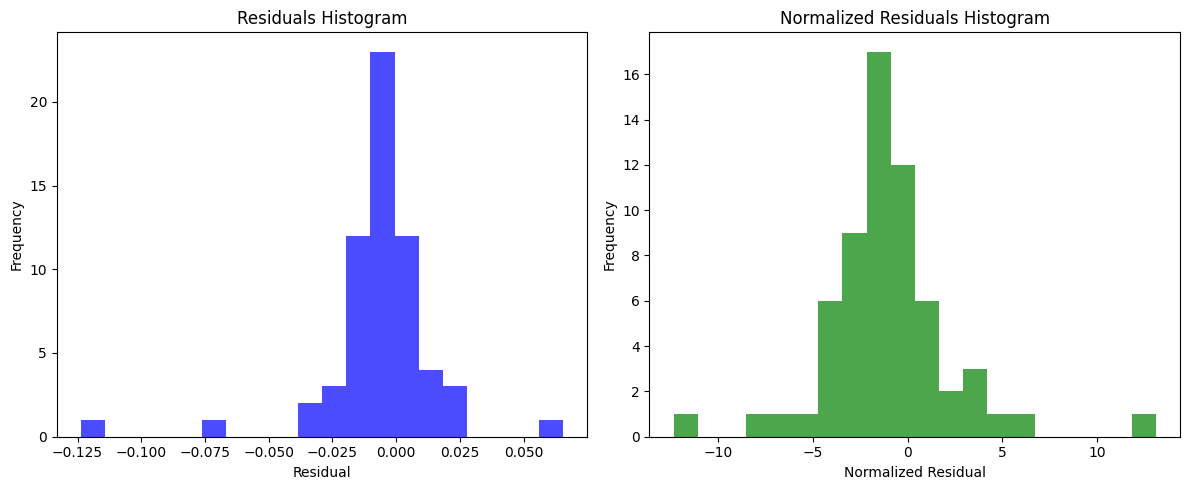

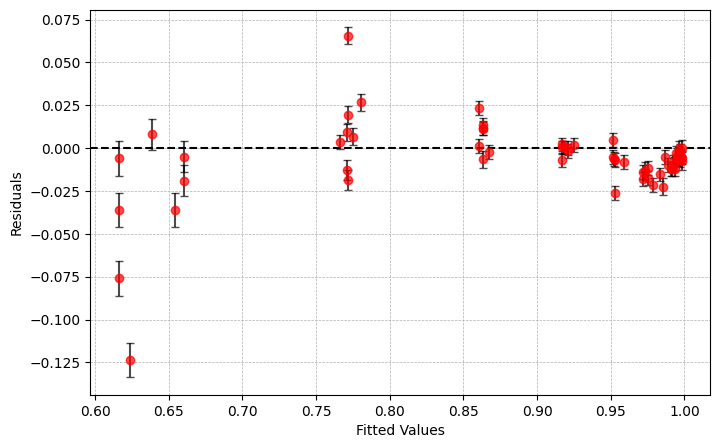


Fitting model: FA
Residual analysis for model FA:
Number of points: 62
Mean residual: -0.0016
Std residual: 0.0184
Mean norm residual: -0.1435
Std norm residual: 2.7261
Outliers (>3 sigma): 7 at indices [30 39 44 48 56 57 60]


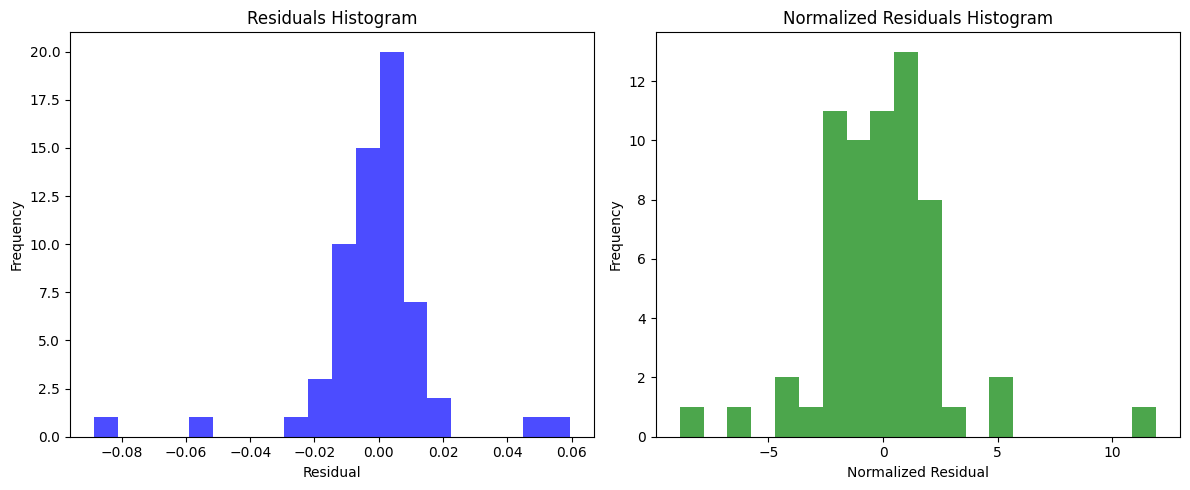

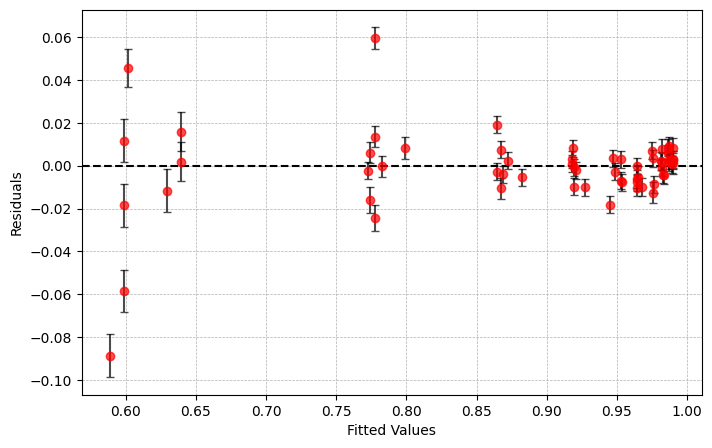


Fitting model: FC
Residual analysis for model FC:
Number of points: 62
Mean residual: -0.0022
Std residual: 0.0200
Mean norm residual: -0.2289
Std norm residual: 2.8932
Outliers (>3 sigma): 9 at indices [30 39 44 46 48 55 56 57 60]


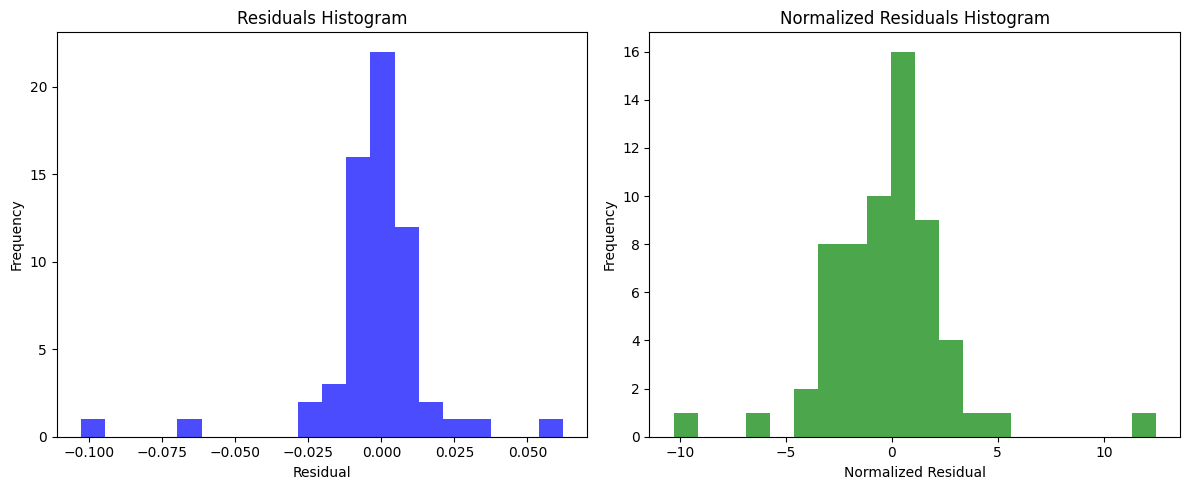

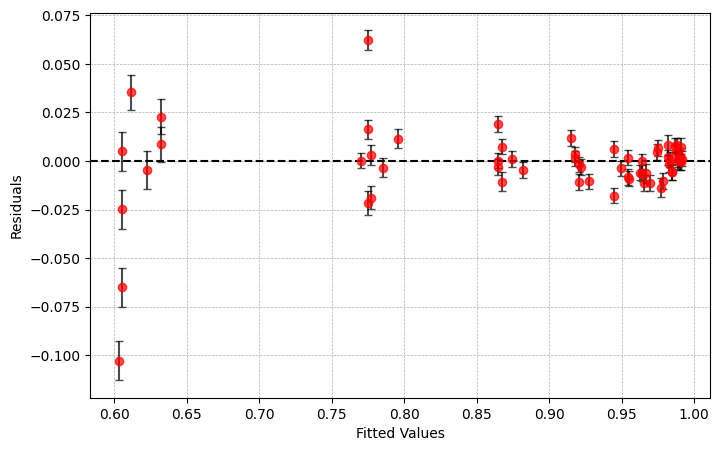


Final Model Summary:
  Model             $c_0$            $c_1$              $c_2$  \
0    PA   6.8437 (0.0902)  0.2188 (0.0027)  -12.0867 (0.1194)   
1    PC  -5.2900 (0.0406)  0.2240 (0.0027)  -11.1173 (0.1058)   
2    FA  -7.0284 (0.2203)  0.1025 (0.0040)   -9.4187 (1.0184)   
3    FC  -9.0158 (0.4222)  0.1553 (0.0085)  -17.4781 (1.8878)   

              $c_3$ Reduced chi^2  
0                --       16.2743  
1                --       13.4376  
2   0.5073 (0.0179)        7.9663  
3  -0.7111 (0.0375)        9.0036  

Final Numeric Model Summary:
  Model       c_0   c_0_err       c_1   c_1_err        c_2   c_2_err  \
0    PA  6.843676  0.090171  0.218763  0.002667 -12.086687  0.119415   
1    PC -5.289972  0.040575  0.224031  0.002695 -11.117321  0.105812   
2    FA -7.028380  0.220340  0.102473  0.003990  -9.418683  1.018398   
3    FC -9.015767  0.422213  0.155302  0.008530 -17.478095  1.887822   

        c_3   c_3_err  Reduced_chi2  
0       NaN       NaN     16.274291  
1    

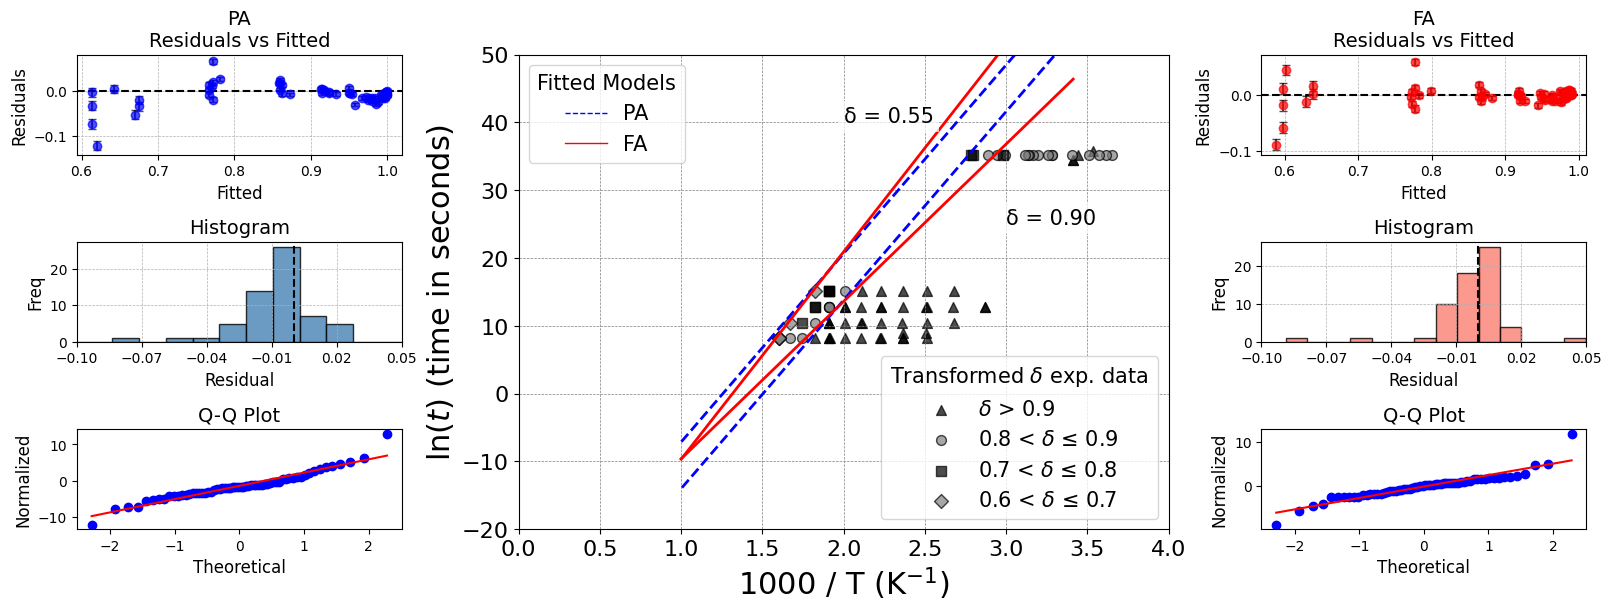

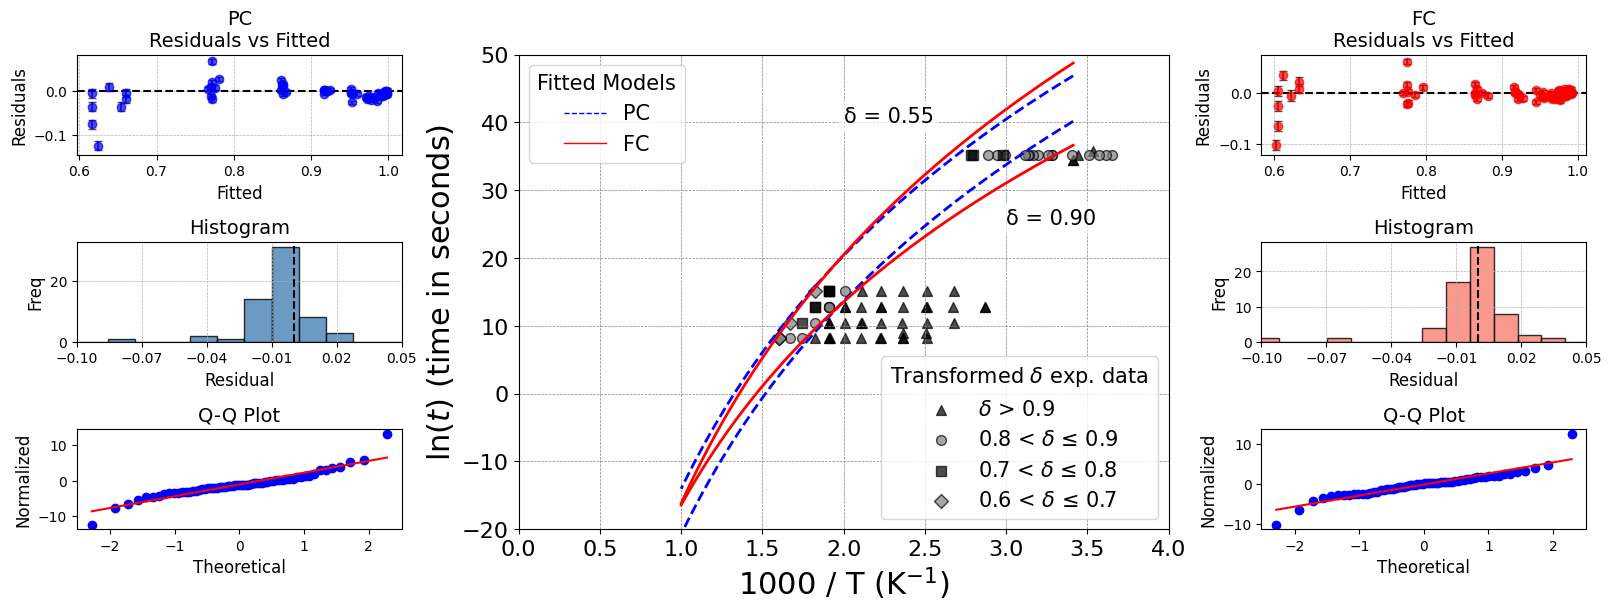

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator  

R_GAS = 1.987204258e-3  # Gas constant kcal/(mol*K)

def convert_r_rho(r):
    """
    Convert track length ratio (r) to normalized density (rho)
    for Durango apatite using a calibrated empirical formula.

    Parameters:
    r : array_like
        Track length ratio.

    Returns:
    rho : array_like
        Normalized density corresponding to r.
    """
    k = 0.108
    l0 = 14.24
    n = 8
    numerator = r * (1 - 1 / (1 + (k * l0 * r) ** n) ** 2)
    denominator = 1 - 1 / (1 + (k * l0) ** n) ** 2
    return numerator / denominator

def prop(r, ur):
    """
    Propagate uncertainties from r and l0 into uncertainty in rho.

    Parameters:
    r : array_like
        Track length ratio.
    ur : array_like
        Uncertainty in r.

    Returns:
    uncertainty_rho : array_like
        Propagated uncertainty in rho.
    """
    k = 0.108
    l0 = 14.24
    ul0 = 0.08
    n = 8
    kl0 = k * l0
    kl0_r = kl0 * r
    term_kl0_n = (1 + kl0 ** n)
    term_kl0r_n = (1 + kl0_r ** n)

    num1 = (2 * k * n * r**2 * kl0_r**(n - 1)) / ((1 - 1 / term_kl0_n**2) * term_kl0r_n**3)
    num2 = (2 * k * kl0**(n - 1) * n * r * (1 - 1 / term_kl0r_n**2)) / ((1 + kl0**n)**3 * (1 - 1 / term_kl0_n**2)**2)
    term_ul0 = num1 - num2

    num3 = (2 * kl0 * n * r * kl0_r**(n - 1)) / ((1 - 1 / term_kl0_n**2) * term_kl0r_n**3)
    num4 = (1 - 1 / term_kl0r_n**2) / (1 - 1 / term_kl0_n**2)
    term_ur = num3 + num4

    uncert_ul0 = term_ul0**2 * ul0**2
    uncert_ur = term_ur**2 * ur**2
    return np.sqrt(uncert_ul0 + uncert_ur)

def truncate_to_first_significant(value, uncertainty):
    """
    Round a value to the first significant digit of its uncertainty.

    Parameters:
    value : float
        Value to be truncated.
    uncertainty : float
        Associated uncertainty of the value.

    Returns:
    float
        Value rounded to the first significant digit of uncertainty.
    """
    if uncertainty == 0:
        return value
    decimal_places = -int(np.floor(np.log10(abs(uncertainty))))
    factor = 10 ** decimal_places
    return np.round(value * factor) / factor

def truncate_df_to_uncertainty(df, target_column, uncertainty_column):
    """
    Apply rounding of values in a DataFrame column based on their uncertainties.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing the data.
    target_column : str
        Name of the column to round.
    uncertainty_column : str
        Name of the column with uncertainties.

    Returns:
    pandas.DataFrame
        DataFrame with truncated values and uncertainties.
    """
    df[target_column] = df.apply(lambda row: truncate_to_first_significant(row[target_column], row[uncertainty_column]), axis=1)
    df[uncertainty_column] = df[uncertainty_column].apply(lambda x: truncate_to_first_significant(x, x))
    return df

def f_PA(tT, c0, c1, c2):
    """
    Parallel-Arrhenius kinetic model function.

    Parameters:
    tT : tuple
        Tuple of (time, temperature).
    c0, c1, c2 : float
        Model parameters.

    Returns:
    float
        Model prediction (log scale).
    """
    t, T = tT
    return c0 + c1 * np.log(t) + c2 / (R_GAS * T)

def lnt_PA(T, rho, params):
    """
    Calculate ln(time) as function of temperature and normalized density for PA model.

    Parameters:
    T : array_like
        Temperature in K.
    rho : float or array_like
        Normalized density.
    params : list or array_like
        Model parameters [c0, c1, c2].

    Returns:
    array_like
        ln(time) values.
    """
    c0, c1, c2 = params
    return np.log(1 - rho) / c1 - (c2 / c1) / (R_GAS * T) - c0 / c1

def f_PC(tT, c0, c1, c2):
    """
    Parallel-Curvilinear kinetic model function.

    Parameters:
    tT : tuple
        Tuple of (time, temperature).
    c0, c1, c2 : float
        Model parameters.

    Returns:
    float
        Model prediction (log scale).
    """
    t, T = tT
    return c0 + c1 * np.log(t) + c2 * np.log(1 / (R_GAS * T))

def lnt_PC(T, rho, params):
    """
    Calculate ln(time) as function of temperature and normalized density for PC model.

    Parameters:
    T : array_like
        Temperature in K.
    rho : float or array_like
        Normalized density.
    params : list or array_like
        Model parameters [c0, c1, c2].

    Returns:
    array_like
        ln(time) values.
    """
    c0, c1, c2 = params
    return np.log(1 - rho) / c1 - (c2 / c1) * np.log(1 / (R_GAS * T)) - c0 / c1

def f_FA(tT, c0, c1, c2, c3):
    """
    Fanning-Arrhenius kinetic model function.

    Parameters:
    tT : tuple
        Tuple of (time, temperature).
    c0, c1, c2, c3 : float
        Model parameters.

    Returns:
    float
        Model prediction (log scale).
    """
    t, T = tT
    return c0 + c1 * (np.log(t) - c2) / (1 / (R_GAS * T) - c3)

def lnt_FA(T, rho, params):
    """
    Calculate ln(time) as function of temperature and normalized density for FA model.

    Parameters:
    T : array_like
        Temperature in K.
    rho : float or array_like
        Normalized density.
    params : list or array_like
        Model parameters [c0, c1, c2, c3].

    Returns:
    array_like
        ln(time) values.
    """
    c0, c1, c2, c3 = params
    numerator = c1 * c2 * R_GAS * T + c0 * (-1 + c3 * R_GAS * T) + (1 - c3 * R_GAS * T) * np.log(1 - rho)
    denominator = c1 * R_GAS * T
    return numerator / denominator

def f_FC(tT, c0, c1, c2, c3):
    """
    Fanning-Curvilinear kinetic model function.

    Parameters:
    tT : tuple
        Tuple of (time, temperature).
    c0, c1, c2, c3 : float
        Model parameters.

    Returns:
    float
        Model prediction (log scale).
    """
    t, T = tT
    return c0 + c1 * (np.log(t) - c2) / (np.log(1 / (R_GAS * T)) - c3)

def lnt_FC(T, rho, params):
    """
    Calculate ln(time) as function of temperature and normalized density for FC model.

    Parameters:
    T : array_like
        Temperature in K.
    rho : float or array_like
        Normalized density.
    params : list or array_like
        Model parameters [c0, c1, c2, c3].

    Returns:
    array_like
        ln(time) values.
    """
    c0, c1, c2, c3 = params
    return (c1 * c2 + c0 * c3 - c3 * np.log(1 - rho) + np.log(1 / (R_GAS * T)) * (-c0 + np.log(1 - rho))) / c1

def load_and_process_data(file_path):
    """
    Load data from file, truncate uncertainties, convert r to rho,
    propagate uncertainties, and truncate again.

    Parameters:
    file_path : str
        Path to the input data file.

    Returns:
    pandas.DataFrame
        Processed data with columns: time, temperature, rho, and uncertainties.
    """
    df = pd.read_csv(file_path, sep=r"\s+", engine='python')
    df = truncate_df_to_uncertainty(df, 'r', 'e.r')
    processed = df.iloc[:, [4, 5, 6, 7]].copy()
    processed.loc[:, 'rho'] = convert_r_rho(df['r'])
    processed.loc[:, 'e.rho'] = prop(df['r'], df['e.r'])
    processed = truncate_df_to_uncertainty(processed, 'rho', 'e.rho')
    return processed

def DAM_fit(model_function, initial_params):
    """
    Fit kinetic annealing model to Durango data using nonlinear least squares.

    Parameters:
    model_function : function
        Model function predicting log(rho) from (time, temperature) and params.
    initial_params : list or array_like
        Initial guess for model parameters.

    Returns:
    dict
        Fit results: parameters, errors, residuals, R^2, chi-squared metrics, etc.
    """
    t_data = dataDurango['tempoS']
    T_data = dataDurango['temperK']
    rho_data = dataDurango['rho']
    sigma_f = dataDurango['e.rho']

    def rho_model(tT, *params):
        return 1 - np.exp(model_function(tT, *params))

    params, covariance = curve_fit(
        rho_model,
        (t_data, T_data),
        rho_data,
        sigma=sigma_f,
        absolute_sigma=True,
        p0=initial_params
    )

    errors = np.sqrt(np.diag(covariance))
    fitted_values = rho_model((t_data, T_data), *params)
    residuals = rho_data - fitted_values

    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((rho_data - np.mean(rho_data)) ** 2)
    r_squared = 1 - ss_res / ss_tot
    chi_squared = np.sum((residuals / sigma_f) ** 2)
    reduced_chi_squared = chi_squared / (len(rho_data) - len(params))

    return {
        "params": params,
        "errors": errors,
        "r_squared": r_squared,
        "chi_squared": chi_squared,
        "reduced_chi_squared": reduced_chi_squared,
        "fitted_values": fitted_values,
        "residuals": residuals,
        "sigma": sigma_f
    }

def analyze_residuals(df):
    """
    Analyze and plot residuals from model fitting.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing columns: 'residuals', 'sigma', 'fitted_values'.

    Prints:
    - Summary statistics of residuals.
    - Histogram of residuals and normalized residuals.
    - Residuals versus fitted values plot.
    """
    residuals = df['residuals'].values
    sigma = df['sigma'].values
    fitted = df['fitted_values'].values
    norm_residuals = residuals / sigma

    print(f"Number of points: {len(residuals)}")
    print(f"Mean residual: {np.mean(residuals):.4f}")
    print(f"Std residual: {np.std(residuals):.4f}")
    print(f"Mean norm residual: {np.mean(norm_residuals):.4f}")
    print(f"Std norm residual: {np.std(norm_residuals):.4f}")

    outliers = np.where(np.abs(norm_residuals) > 3)[0]
    print(f"Outliers (>3 sigma): {len(outliers)} at indices {outliers}")

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hist(residuals, bins=20, color='blue', alpha=0.7)
    plt.title("Residuals Histogram")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")

    plt.subplot(1,2,2)
    plt.hist(norm_residuals, bins=20, color='green', alpha=0.7)
    plt.title("Normalized Residuals Histogram")
    plt.xlabel("Normalized Residual")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.errorbar(fitted, residuals, yerr=sigma, fmt='o', color='red', ecolor='black', capsize=3, alpha=0.7)
    plt.axhline(0, linestyle='--', color='black')
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()




def plot_pseudo_arrhenius_dual(
    dDKTB,
    lnt_model_A, lnt_model_B,
    params_A, params_B,
    model_name_A, model_name_B,
    residuals_A, fitted_A, sigma_A,
    residuals_B, fitted_B, sigma_B
):
    # Create a temperature array from 293 K to 925 K with 200 points
    Temps = np.linspace(293, 1000, 200)

    # Calculate normalized residuals by dividing residuals by their standard deviations (sigma)
    norm_residuals_A = residuals_A / sigma_A
    norm_residuals_B = residuals_B / sigma_B

    # Create a figure with specific size and enable constrained layout for automatic spacing
    fig = plt.figure(figsize=(16, 6),constrained_layout=True)

    # Define a grid layout with 3 rows and 5 columns for arranging subplots
    # Width ratios give the middle column more space (3.2x)
    gs = gridspec.GridSpec(3, 3, figure=fig, width_ratios=[1, 2.0, 1], wspace=0)

    # Main plot (ln(t) vs 1000/T) placed at all rows of column index 2 (center wide column)
    ax_main = fig.add_subplot(gs[:, 1])

    # Left diagnostics subplots for model A: Residuals, Histogram, Q-Q plot
    ax_resid_A = fig.add_subplot(gs[0, 0])
    ax_hist_A = fig.add_subplot(gs[1, 0])
    ax_qq_A = fig.add_subplot(gs[2, 0])

    # Right diagnostics subplots for model B: Residuals, Histogram, Q-Q plot
    ax_resid_B = fig.add_subplot(gs[0, 2])
    ax_hist_B = fig.add_subplot(gs[1, 2])
    ax_qq_B = fig.add_subplot(gs[2, 2])

    # Define groups of data points by 'rho' intervals with marker styles and colors
    groups = [
        (dDKTB['rho'] > 0.9, '^', 'black', 'black', r'$\delta$ > 0.9'),
        ((dDKTB['rho'] > 0.8) & (dDKTB['rho'] <= 0.9), 'o', 'gray', 'black', r'0.8 < $\delta$ ≤ 0.9'),
        ((dDKTB['rho'] > 0.7) & (dDKTB['rho'] <= 0.8), 's', 'black', 'black', r'0.7 < $\delta$ ≤ 0.8'),
        ((dDKTB['rho'] > 0.6) & (dDKTB['rho'] <= 0.7), 'D', 'gray', 'black', r'0.6 < $\delta$ ≤ 0.7'),
    ]

    # Prepare lists to store scatter plot handles and labels for separate legend
    scatter_handles = []
    scatter_labels = []

    # Plot experimental data points by groups with specified markers and colors
    for cond, marker, facecolor, edgecolor, label in groups:
        subset = dDKTB.loc[cond]
        x = 1000 / subset['temperK']      # Convert temperature to 1000/T scale
        y = np.log(subset['tempoS'])     # Take natural log of time in seconds
        sc = ax_main.scatter(x, y, s=50, c=facecolor, marker=marker,
                            edgecolor=edgecolor, alpha=0.7, label=label)
        scatter_handles.append(sc)       # Save scatter handles for legend
        scatter_labels.append(label)     # Save corresponding labels

    # Prepare lists for line plot handles and labels (model curves)
    line_handles = []
    line_labels = []

    # Plot model A curves for delta=0.55 (solid) and delta=0.9 (dashed)
    line1 = ax_main.plot(1000 / Temps, lnt_model_A(Temps, 0.55, params_A),
                        color='blue', linestyle='--', label=f'{model_name_A}: δ=0.55', linewidth=2)
    line2 = ax_main.plot(1000 / Temps, lnt_model_A(Temps, 0.9, params_A),
                        color='blue', linestyle='--', label=f'{model_name_A}: δ=0.90', linewidth=2)

    # Plot model B curves similarly
    line3 = ax_main.plot(1000 / Temps, lnt_model_B(Temps, 0.55, params_B),
                        color='red', label=f'{model_name_B}: δ=0.55', linewidth=2)
    line4 = ax_main.plot(1000 / Temps, lnt_model_B(Temps, 0.9, params_B),
                        color='red', label=f'{model_name_B}: δ=0.90', linewidth=2)

    # Extract Line2D objects from the lists returned by plot (each is a list of lines)
    line_handles.extend([line1[0], line2[0], line3[0], line4[0]])
    line_labels.extend([
        f'{model_name_A}: δ=0.55',
        f'{model_name_A}: δ=0.90',
        f'{model_name_B}: δ=0.55',
        f'{model_name_B}: δ=0.90'
    ])

    # Set axis labels with LaTeX formatting and larger font size
    ax_main.set_xlabel(r'1000 / T (K$^{-1}$)', fontsize=22)
    ax_main.set_ylabel(r'$\ln(t)$ (time in seconds)', fontsize=22)

    # Define axis limits for x and y axes
    ax_main.set_xlim(0, 4)
    ax_main.set_ylim(-20, 50)

    # Enable grid with dashed gray lines and thin linewidth
    ax_main.grid(True, linestyle='--', color='gray', linewidth=0.5)

    # Set size of tick labels on axes
    ax_main.tick_params(labelsize=16)

    # Create the first legend for experimental data points, placing it at upper right
    legend_exp = ax_main.legend(handles=scatter_handles, labels=scatter_labels,
                               loc='lower right', fontsize=15, title=r'Transformed $\delta$ exp. data ')
    legend_exp.get_title().set_fontsize(15)

    # Add this legend explicitly to the axes so it does not get overwritten
    ax_main.add_artist(legend_exp)

    # Legend for models colors only
    from matplotlib.lines import Line2D
    model_legend_handles = [
        Line2D([0], [0], color='blue', linestyle='--', lw=1, label=model_name_A),
        Line2D([0], [0], color='red', lw=1, label=model_name_B)
    ]
    legend_model = ax_main.legend(handles=model_legend_handles, loc='upper left',
                                  fontsize=15, title='Fitted Models')
    legend_model.get_title().set_fontsize(15)
    
    # Add text annotations to indicate δ values for the curves
    ax_main.text(2.0, 40, 'δ = 0.55', color='black', fontsize=15,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax_main.text(3.0, 25, 'δ = 0.90', color='black', fontsize=15,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Style dictionary for subplot titles (font size and padding)
    title_style = dict(fontsize=14, pad=6)

    # --- Diagnostics for Model A ---

    # Plot residuals vs fitted values with error bars (sigma_A)
    ax_resid_A.errorbar(fitted_A, residuals_A, yerr=sigma_A, fmt='o', color='blue',
                       ecolor='black', capsize=3, alpha=0.7)
    ax_resid_A.axhline(0, linestyle='--', color='black')  # Horizontal line at zero residual
    ax_resid_A.set_title(f"{model_name_A}\nResiduals vs Fitted", **title_style)
    ax_resid_A.set_xlabel("Fitted", fontsize=12)
    ax_resid_A.set_ylabel("Residuals", fontsize=12)
    ax_resid_A.tick_params(labelsize=10)
    ax_resid_A.grid(True, linestyle='--', linewidth=0.5)

    # Histogram of residuals to check distribution shape
    ax_hist_A.hist(residuals_A, bins=15, color='steelblue', alpha=0.8, edgecolor='black')
    ax_hist_A.axvline(0, color='black', linestyle='--')  # Vertical line at zero
    ax_hist_A.set_title("Histogram", **title_style)
    ax_hist_A.set_xlabel("Residual", fontsize=12)
    ax_hist_A.set_ylabel("Freq", fontsize=12)
    ax_hist_A.tick_params(labelsize=10)
    ax_hist_A.grid(True, linestyle='--', linewidth=0.5)

    # Força numero de ticks no eixo x para histogram A
    tick_vals = np.linspace(-0.1, 0.05, 6)  # ou ajuste a quantidade conforme quiser
    ax_hist_A.set_xlim(-0.1, 0.05)
    ax_hist_A.set_xticks(tick_vals)

    # Q-Q plot to compare residuals distribution with normal distribution
    stats.probplot(norm_residuals_A, dist="norm", plot=ax_qq_A)
    ax_qq_A.set_title("Q-Q Plot", **title_style)
    ax_qq_A.set_xlabel("Theoretical", fontsize=12)
    ax_qq_A.set_ylabel("Normalized", fontsize=12)
    ax_qq_A.tick_params(labelsize=10)

    # --- Diagnostics for Model B ---

    ax_resid_B.errorbar(fitted_B, residuals_B, yerr=sigma_B, fmt='o', color='red',
                       ecolor='black', capsize=3, alpha=0.7)
    ax_resid_B.axhline(0, linestyle='--', color='black')
    ax_resid_B.set_title(f"{model_name_B}\nResiduals vs Fitted", **title_style)
    ax_resid_B.set_xlabel("Fitted", fontsize=12)
    ax_resid_B.set_ylabel("Residuals", fontsize=12)
    ax_resid_B.tick_params(labelsize=10)
    ax_resid_B.grid(True, linestyle='--', linewidth=0.5)

    ax_hist_B.hist(residuals_B, bins=15, color='salmon', alpha=0.8, edgecolor='black')
    ax_hist_B.axvline(0, color='black', linestyle='--')
    ax_hist_B.set_title("Histogram", **title_style)
    ax_hist_B.set_xlabel("Residual", fontsize=12)
    ax_hist_B.set_ylabel("Freq", fontsize=12)
    ax_hist_B.tick_params(labelsize=10)
    ax_hist_B.grid(True, linestyle='--', linewidth=0.5)

    # Força mesmo número de ticks no eixo x
    ax_hist_B.set_xlim(-0.1, 0.05)
    ax_hist_B.set_xticks(tick_vals)

    stats.probplot(norm_residuals_B, dist="norm", plot=ax_qq_B)
    ax_qq_B.set_title("Q-Q Plot", **title_style)
    ax_qq_B.set_xlabel("Theoretical", fontsize=12)
    ax_qq_B.set_ylabel("Normalized", fontsize=12)
    ax_qq_B.tick_params(labelsize=10)

    # Save figure as a PNG file with high resolution and tight bounding box
    plt.savefig(f"PsArrh_{model_name_A}_{model_name_B}.png", dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

    # Close the plot to free memory
    plt.close()



def plot_dual_model_with_sidepanels(dDKTB, modelA, modelB, model1, model2):
    plot_pseudo_arrhenius_dual(
        dDKTB,
        modelA["lnt"], modelB["lnt"],
        modelA["params"], modelB["params"],
        modelA["name"], modelB["name"],
        modelA["residuals"], modelA["fitted"], modelA["sigma"],
        modelB["residuals"], modelB["fitted"], modelB["sigma"]
    )

def main():
    """
    Main execution function:
    - Loads and preprocesses data
    - Fits models to Durango and KTB data
    - Analyzes residuals
    - Plots pseudo-Arrhenius plots with side panels
    - Saves fit summary and residual data
    """
    print("Current working directory:", os.getcwd())

    global dataDurango, dataKTB
    dataDurango = load_and_process_data('DurangoDataR.txt')
    dataKTB = load_and_process_data('KTB.txt')

    appendix_KTB = pd.DataFrame({
        'time (s)': dataKTB['tempoS'],
        'temperature (K)': dataKTB['temperK'],
        'rho': dataKTB['rho'],
        'e.rho': dataKTB['e.rho']
    })
    appendix_KTB.to_csv('annealing_appendix_data_KTB.csv', index=False, float_format='%.4g')

    appendix_Durango = pd.DataFrame({
        'time (s)': dataDurango['tempoS'],
        'temperature (K)': dataDurango['temperK'],
        'rho': dataDurango['rho'],
        'e.rho': dataDurango['e.rho']
    })
    appendix_Durango.to_csv('annealing_appendix_data_DURANGO.csv', index=False, float_format='%.4g')

    models = {
        "PA": {"func": f_PA, "initial": [5.631, 0.1865, -10.46], "lnt": lnt_PA},
        "PC": {"func": f_PC, "initial": [-4.910, 0.1944, -9.610], "lnt": lnt_PC},
        "FA": {"func": f_FA, "initial": [-8.518, 0.1266, -20.99, 0.2985], "lnt": lnt_FA},
        "FC": {"func": f_FC, "initial": [-9.449, 0.1627, -24.58, -0.8626], "lnt": lnt_FC},
    }

    combined_data = pd.concat([dataDurango, dataKTB], ignore_index=True)

    results = []
    results_numeric = []  # NOVA lista para valores e erros separados
    fit_results = {}
    
    for name, model in models.items():
        print(f"\nFitting model: {name}")
        res = DAM_fit(model["func"], model["initial"])
        fit_results[name] = res
    
        res_df = pd.DataFrame({
            "fitted_values": res["fitted_values"],
            "residuals": res["residuals"],
            "sigma": res["sigma"]
        })
        res_df.to_csv(f"residuals_{name}.csv", index=False)
    
        print(f"Residual analysis for model {name}:")
        analyze_residuals(res_df)
    
        params = list(res["params"])
        errors = list(res["errors"])
        while len(params) < 4:
            params.append(None)
            errors.append(None)
    
        # Salva para o CSV formatado (string com erro)
        results.append({
            "Model": name,
            "$c_0$": f"{params[0]:.4f} ({errors[0]:.4f})" if params[0] is not None else "--",
            "$c_1$": f"{params[1]:.4f} ({errors[1]:.4f})" if params[1] is not None else "--",
            "$c_2$": f"{params[2]:.4f} ({errors[2]:.4f})" if params[2] is not None else "--",
            "$c_3$": f"{params[3]:.4f} ({errors[3]:.4f})" if params[3] is not None else "--",
            "Reduced chi^2": f"{res['reduced_chi_squared']:.4f}"
        })
    
        # Salva para o CSV numérico (valores e erros separados)
        results_numeric.append({
            "Model": name,
            "c_0": params[0],
            "c_0_err": errors[0],
            "c_1": params[1],
            "c_1_err": errors[1],
            "c_2": params[2],
            "c_2_err": errors[2],
            "c_3": params[3],
            "c_3_err": errors[3],
            "Reduced_chi2": res['reduced_chi_squared']
        })
    
    # Fora do loop, salva os dois CSVs:
    summary_df = pd.DataFrame(results)
    summary_df.to_csv("model_fit_summary.csv", index=False)
    with open("model_fit_summary.tex", "w") as f:
        f.write(summary_df.to_latex(index=False, float_format="%.4f", na_rep="--"))
    
    summary_numeric_df = pd.DataFrame(results_numeric)
    summary_numeric_df.to_csv("model_fit_summary_numeric.csv", index=False)
    
    print("\nFinal Model Summary:")
    print(summary_df)
    
    print("\nFinal Numeric Model Summary:")
    print(summary_numeric_df)

    # Gera figuras com pares de modelos e sidepanels
    dual_models = {
        "Arrhenius": ("PA", "FA"),
        "Curvilinear": ("PC", "FC"),
    }

    for group, (model1, model2) in dual_models.items():
        modelA = {
            "name": model1,
            "lnt": models[model1]["lnt"],
            "params": fit_results[model1]["params"],
            "fitted": fit_results[model1]["fitted_values"],
            "residuals": fit_results[model1]["residuals"],
            "sigma": fit_results[model1]["sigma"]
        }
        modelB = {
            "name": model2,
            "lnt": models[model2]["lnt"],
            "params": fit_results[model2]["params"],
            "fitted": fit_results[model2]["fitted_values"],
            "residuals": fit_results[model2]["residuals"],
            "sigma": fit_results[model2]["sigma"]
        }
        plot_dual_model_with_sidepanels(combined_data, modelA, modelB, model1, model2)

if __name__ == "__main__":
    main()


